In [36]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import re 
import pickle
import tensorflow as tf  
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout, Flatten, Embedding, Bidirectional, Input, GlobalMaxPool1D

import warnings
warnings.filterwarnings('ignore')

# Read Data

In [3]:
columns = ['id', 'country', 'label', 'text']
train_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', names=columns)
val_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', names = columns)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       74682 non-null  int64 
 1   country  74682 non-null  object
 2   label    74682 non-null  object
 3   text     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1000 non-null   int64 
 1   country  1000 non-null   object
 2   label    1000 non-null   object
 3   text     1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [6]:
train_df.isna().sum()

id           0
country      0
label        0
text       686
dtype: int64

In [7]:
train_df.dropna(axis= 0, inplace = True)

In [8]:
train_df.columns

Index(['id', 'country', 'label', 'text'], dtype='object')

In [9]:
train_df.drop(columns = ['id', 'country'], axis= 1, inplace=True)
val_df.drop(columns = ['id', 'country'], axis= 1, inplace=True)

In [10]:
train_df['label'].value_counts()

label
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

In [11]:
# Remove unnecessary label
train_df = train_df[train_df['label'] != 'Irrelevant']
val_df = val_df[val_df['label'] != 'Irrelevant']

In [12]:
count_label = train_df['label'].value_counts()
count_label

label
Negative    22358
Positive    20655
Neutral     18108
Name: count, dtype: int64

<BarContainer object of 3 artists>

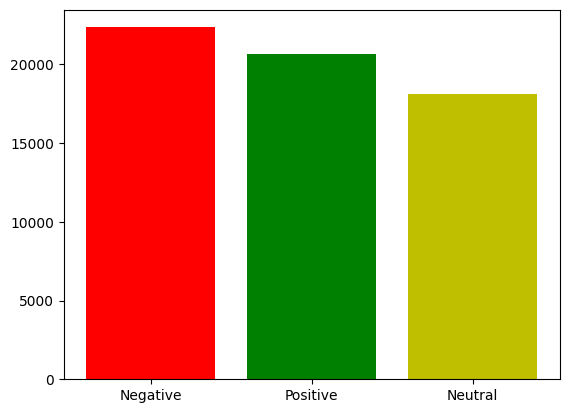

In [13]:
plt.bar(count_label.index, count_label.values, color = ['r','g', 'y'])

# Data Cleaning

In [14]:

def clean_text(text):
    text = text.lower()
    # Remove HTML tags (e.g., <p>, <div>)
    text = re.sub(r'<[^>]+>', '', text)
    # Remove mentions (e.g., @username)
    text = re.sub(r'@\w+|[(d)]|@ \w+', '', text)
    text = re.sub(r'http\w+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[(?!)|(+%)|(*)]|[_]|[$]|[:)]', '', text)
    text = re.sub(r'(\.)|(\;)|(\:)|(\')|(\,)|(\")|(\()|(\))|(\[)|(\])|(~)|(\d+)|(-)|(//)|(/)', '', text)
    
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
val_df['cleaned_text'] = val_df['text'].apply(clean_text)

In [15]:
train_df[train_df['label'] == 'Negative']['cleaned_text'].tolist()[:20]

['the biggest issappoinment in my life came out a year ago fuck borerlans ',
 'the biggest isappointment of my life came a year ago',
 'the biggest isappointment of my life came a year ago',
 'the biggest issappoinment in my life coming out a year ago fuck borerlans ',
 'for the biggest male issappoinment in my life came hanging out a year time ago fuck borerlans ',
 'the biggest issappoinment in my life came back last year ago fuck borerlans last',
 'man gearbox really nees to fix this issapointing rops in the new borerlans  lc cant be fine to farm bosses on mayhem  to get  legenary rop while anywhere else i get  rops  really sucks alot',
 'man gearbox really nees to fix these isappointing rops in the new borerlans  lc for farm bosses on mayhem  to get a legenary rop while i get  rops elsewhere',
 'man gearbox really nees to fix this isssapointing rops in the new borerlans  lc cant be fine to farm bosses on mayhem  to get  legenary rop while elsewhere i get  rops really sucks alot',
 

In [48]:
val_df[val_df['label'] == 'Negative']['cleaned_text'].tolist()[:10]

[' why o i pay for wor when it functions so poorly on my chromebook 🙄',
 'csgo matchmaking is so full of closet hacking its a truly awful game',
 'hi i’ve ha maeleine mccann in my cellar for the past  years an the little sneaky thing just escape whilst i was loaing up some fifa points she took my car an i’m having to use my paypal account but it isn’t working can you help me resolve it please',
 'fix it jesus  please fix it  what in the worl is going on here negative  silver wolf error coe pictwittercomziryhrfq',
 ' hey fre comcast cut the cable an now verizon stays calling me to shut that too pictwittercomcpwsrmueg',
 ' game sucks own by  with  secons left an my team intentionally fouls',
 'fuck my life 😆',
 'what oes that say about microsoft harware & software security  the man gets hacke',
 'the new for ps is 🔥🔥🔥🔥 oh go 😭😍',
 'finally playe rainbow six siege for the first time i have to amit i prefer it over pulling my hair out in csgo any ay']

# Convert Words to Numbers & Padding

In [17]:
oov_tok = '<OOV>'
max_pad = 64
embedding_dim = 200
num_word = 5000

In [18]:
tokenizer = Tokenizer(num_words=num_word, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['cleaned_text'])
word_index = tokenizer.word_index

In [19]:
# Convert to Seq 
train_seq = tokenizer.texts_to_sequences(train_df['cleaned_text'])
val_seq = tokenizer.texts_to_sequences(val_df['cleaned_text'])

In [20]:
train_pad = pad_sequences(train_seq, maxlen= max_pad, truncating='post', padding='post')
val_pad = pad_sequences(val_seq, maxlen= max_pad, truncating='post', padding='post')

In [21]:
# labels 
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_df['label'])

train_label_seq = np.array(label_tokenizer.texts_to_sequences(train_df['label']))
val_label_seq = np.array(label_tokenizer.texts_to_sequences(val_df['label']))

In [22]:
train_label_seq

array([[2],
       [2],
       [2],
       ...,
       [2],
       [2],
       [2]])

# build Model

In [39]:
vocab_size = len(word_index)

model = Sequential()
model.add(Input(shape=(200,)))
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5, name = 'Dropout_embedding'))
model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation ='relu', name = 'Dense1'))
model.add(Dropout(0.5, name = 'Dropout_Dense1'))
model.add(Dense(4, activation='softmax', name = 'Dense2'))
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 200)       │     6,131,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_embedding (Dropout)     │ (None, 200, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 400)       │       641,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 400)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 64)             │        25,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Dense1 (Dropout)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,798,924 (25.94 MB)

 Trainable params: 6,798,924 (25.94 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)


history= model.fit(train_pad, train_label_seq, 
                   validation_data=(val_pad, val_label_seq), 
                   epochs=20, batch_size = 64, verbose=2, callbacks = [early_stop])

Epoch 1/20
956/956 - 21s - 22ms/step - accuracy: 0.7010 - loss: 0.7308 - val_accuracy: 0.8490 - val_loss: 0.4034
Epoch 2/20
956/956 - 17s - 18ms/step - accuracy: 0.7931 - loss: 0.5313 - val_accuracy: 0.9130 - val_loss: 0.2731
Epoch 3/20
956/956 - 17s - 17ms/step - accuracy: 0.8333 - loss: 0.4313 - val_accuracy: 0.9287 - val_loss: 0.2341
Epoch 4/20
956/956 - 16s - 17ms/step - accuracy: 0.8596 - loss: 0.3658 - val_accuracy: 0.9336 - val_loss: 0.2003
Epoch 5/20
956/956 - 17s - 17ms/step - accuracy: 0.8795 - loss: 0.3115 - val_accuracy: 0.9432 - val_loss: 0.1753
Epoch 6/20
956/956 - 17s - 17ms/step - accuracy: 0.8948 - loss: 0.2716 - val_accuracy: 0.9481 - val_loss: 0.1670
Epoch 7/20
956/956 - 17s - 17ms/step - accuracy: 0.9068 - loss: 0.2394 - val_accuracy: 0.9589 - val_loss: 0.1559
Epoch 8/20
956/956 - 17s - 17ms/step - accuracy: 0.9157 - loss: 0.2124 - val_accuracy: 0.9541 - val_loss: 0.1536
Epoch 9/20
956/956 - 17s - 17ms/step - accuracy: 0.9236 - loss: 0.1924 - val_accuracy: 0.9626 - 

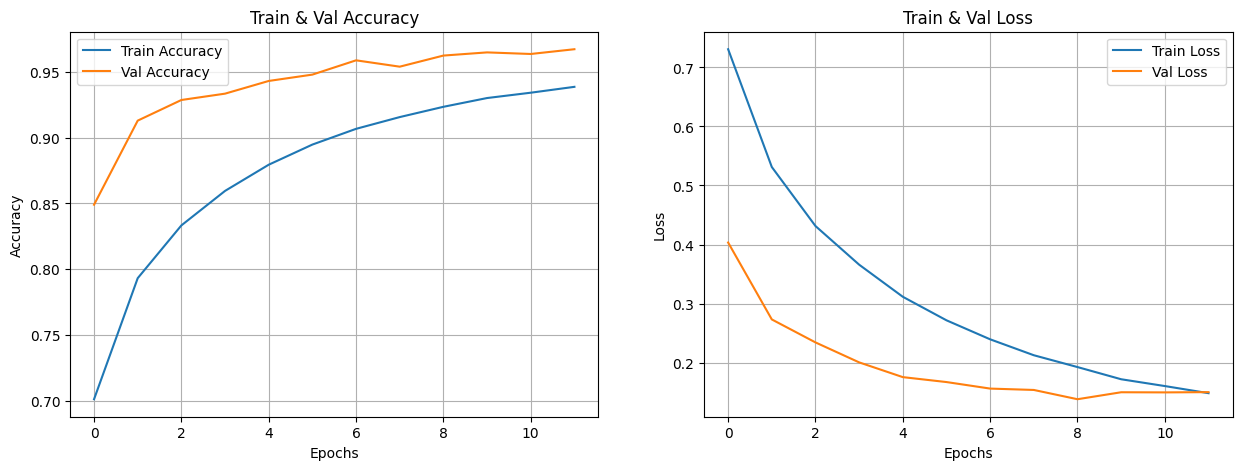

In [44]:
def plot_training(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1,2,1)
    plt.title('Train & Val Accuracy')
    plt.plot(history.history['accuracy'], label = 'Train Accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Train & Val Loss')
    plt.plot(history.history['loss'], label = 'Train Loss')
    plt.plot(history.history['val_loss'], label = 'Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.show()

plot_training(history)